In [123]:
import cv2
import numpy as np
import pandas as pd

#ใช่แบบนี้ไม่ต้องเก็บ buffer เอง
path = 'D:/Git project/cycle_time_monitoring/Clycle-time-monitoring-True-Project/Normal.avi'
cap = cv2.VideoCapture(path)

# setting record
# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4))
# out = cv2.VideoWriter('outpy_2.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

# Get the frames per second
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)

# Get the total numer of frames in the video. value same as image frame
# frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
# print(frame_count)

#Time of video(sec)
# duration = frame_count / fps
# print(duration)

# bgsubknn = cv2.createBackgroundSubtractorKNN(40) # มักจะดีกว่า , default จะเก็บ buffer 400 - 500 grame
# L1 = np.r_[50:53]
# L2 = np.r_[60:63]


L1_status, L2_status = False, False
count = 0
relay = [0, 50, 0]
relay_status = False

timer = 0
process_time = 0
cycle_time = []
std_time = 9
green = (0, 255, 0)
red = (0, 0, 255)
value_frame1 = []
value_frame2 = []

bgsubknn1 = cv2.createBackgroundSubtractorKNN(40)
bgsubknn2 = cv2.createBackgroundSubtractorKNN(40)
y1 = 140
y2 = 200
x1 = 50
x2 = 200

yy1 = 170
yy2 = 250
xx1 = 430
xx2 = 500

process_n = 0 # flase=process, True=double-process
process_s = 0

c=0
u=1
while True:
    ret, img = cap.read()
    if not ret:
        break
    frame = cv2.GaussianBlur(img ,(5,5),0)

    c += 1
    timer += 1
    
    
    crop_frame1 = frame[y1:y2, x1:x2]
    crop_frame2 = frame[yy1:yy2, xx1:xx2]

    fg1 = bgsubknn1.apply(crop_frame1)
    fg2 = bgsubknn2.apply(crop_frame2)

#     print(relay_status)
    # print(np.sum(fg1))
    relay[2] += 1 # action
    if np.sum(fg1) > 100000 and c > 100 and relay[2] > 50:
        L1_status = True
        process_n += 1
    
        relay[2] = 0
    else:
        u=1


    if np.sum(fg2) > 80000 and c > 100 and relay_status == True:
        L2_status = True
    else:
        u=1
    value_frame1.append(np.sum(fg1))
    value_frame2.append(np.sum(fg2))


    # check status
    # print(L1_status, L2_status, relay_status, np.sum(fg1))
    
    if L1_status and L2_status:
        L1_status = False
        L2_status = False

        if relay_status:
            relay_status = False
            L1_status = False
            L2_status = False
            process_n = 0

            count += 1
            print(count)
            

            process_time = timer/fps
            cycle_time.append(process_time)

            print(cycle_time)
            print(sum(cycle_time)/len(cycle_time))
            timer = 0

    process_s = process_n
    # condition relay
    if relay_status == False:
        relay[0] += 1
        

    if relay[0] >= relay[1]:
        relay_status = True
        relay[0] = 0

    
    cv2.putText(img, 'Timer: ' + str(round(timer/fps)) + ' Sec', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    cv2.putText(img, 'Std. time = ' + str(round(std_time)) + ' Sec', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    if process_time > std_time:
        color = red
        cv2.putText(img, 'process_time = ' + str(round(process_time)) + ' Sec', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5,color, 2)
    else:
        color = green
        cv2.putText(img, 'process_time = ' + str(round(process_time)) + ' Sec', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    if process_s == 0:
        txt = 'none'
    elif process_s == 1:
        txt = 'process'
    elif process_s >= 2:
        txt = 'double-process'
    
    cv2.putText(img, 'status: ' + txt, (400, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    

    # out.write(frame)
    cv2.imshow('frame', img)
    cv2.imshow('frame2', fg1)
    cv2.imshow('frame3', fg2)


    key = cv2.waitKey(1)
    if key ==27:
        break

print(cycle_time)


25.0
1
[8.04]
8.04
2
[8.04, 6.52]
7.279999999999999
3
[8.04, 6.52, 6.8]
7.12
4
[8.04, 6.52, 6.8, 6.52]
6.97
5
[8.04, 6.52, 6.8, 6.52, 6.68]
6.912000000000001
6
[8.04, 6.52, 6.8, 6.52, 6.68, 7.56]
7.0200000000000005
7
[8.04, 6.52, 6.8, 6.52, 6.68, 7.56, 6.8]
6.988571428571428
[8.04, 6.52, 6.8, 6.52, 6.68, 7.56, 6.8]


In [4]:
len(value_frame1)

1253

In [5]:
len(value_frame2)

1253

In [42]:
df = pd.DataFrame()
df['fg1'] = value_frame1
df['fg2'] = value_frame2
df['dummy'] = 1
df = df[10:].reset_index(drop = True)
df

,fg1,fg2,dummy
0,54305,0,1
1,52138,254,1
2,46020,254,1
3,37991,637,1
4,35822,1270,1
...,...,...,...
1238,0,25469,1
1239,255,19352,1
1240,0,19862,1
1241,0,17184,1


<AxesSubplot:>

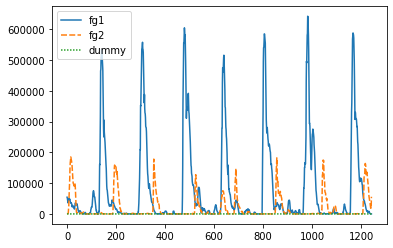

In [43]:
import seaborn as sns
sns.lineplot(data=df)

<AxesSubplot:ylabel='fg2'>

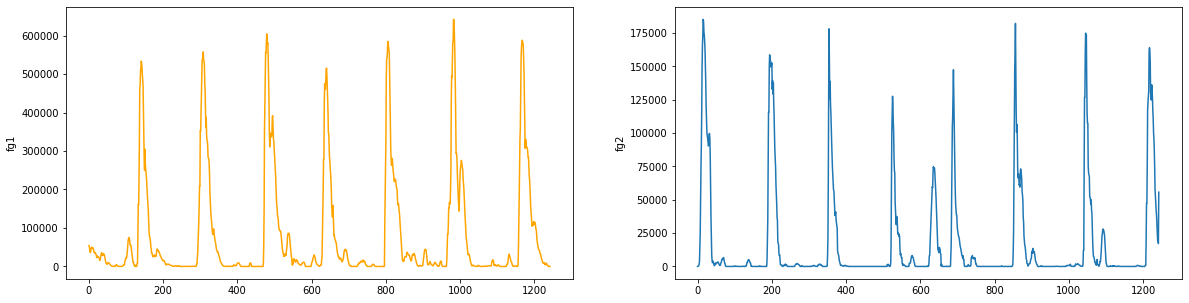

In [69]:
# import seaborn as sns
fg1 = df['fg1']
fg2 = df['fg2']

from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.lineplot(ax=axes[0], data=fg1,color='orange')
sns.lineplot(ax=axes[1], data=fg2)

# sns.lineplot(data=fg2)


In [87]:
X = df[['dummy', 'fg2']]
X

,dummy,fg2
0,1,0
1,1,254
2,1,254
3,1,637
4,1,1270
...,...,...
1238,1,25469
1239,1,19352
1240,1,19862
1241,1,17184


In [102]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(X))
kmeans

KMeans(n_clusters=2, random_state=0)

In [103]:
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [104]:
(unique, counts) = np.unique(kmeans.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0  152]
 [   1 1091]]


In [105]:
kmeans.cluster_centers_[1][1]

4357.550870760808

In [106]:
df['fg2_cls'] = kmeans.labels_
df

,fg1,fg2,dummy,fg1_cls,fg2_cls
0,54305,0,1,1,1
1,52138,254,1,1,1
2,46020,254,1,1,1
3,37991,637,1,1,1
4,35822,1270,1,1,1
...,...,...,...,...,...
1238,0,25469,1,1,1
1239,255,19352,1,1,1
1240,0,19862,1,1,1
1241,0,17184,1,1,1


In [107]:
len(kmeans.labels_)

1243

In [108]:
clss = df.reset_index()
cls0 = clss[clss['fg2_cls'] == 0]
cls1 = clss[clss['fg2_cls'] == 1]


In [109]:
cls0

,index,fg1,fg2,dummy,fg1_cls,fg2_cls
9,9,49328,72947,1,0,0
10,10,46523,89892,1,0,0
11,11,48180,113807,1,0,0
12,12,45758,148304,1,0,0
13,13,41415,165794,1,0,0
...,...,...,...,...,...,...
1228,1228,8155,100012,1,0,0
1229,1229,4076,95681,1,0,0
1230,1230,6496,86646,1,0,0
1231,1231,6621,74029,1,0,0


<AxesSubplot:xlabel='index', ylabel='fg2'>

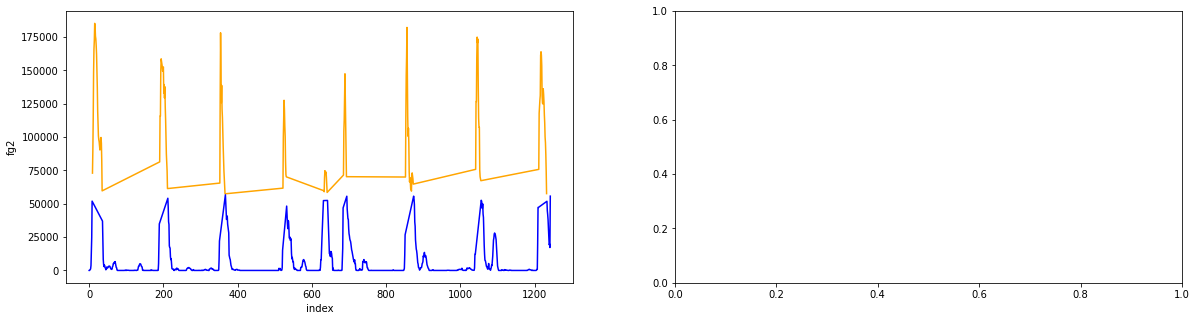

In [111]:
# import seaborn as sns
cls0 = cls0[['fg2', 'index']]
cls1 = cls1[['fg2', 'index']]
# x=bulbasaur.index, y=bulbasaur.values
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.lineplot(ax=axes[0], data=cls0, color ='orange',x="index", y="fg2")
sns.lineplot(ax=axes[0], data=cls1, color ='blue',x="index", y="fg2")

In [121]:
min(cls0['fg2'])*1.5

86161.5

In [119]:
import statistics
statistics.median(cls0['fg2']) *1.2

128721.59999999999

In [139]:
max(df['fg1'])

642551

In [158]:
df = pd.DataFrame()
df['dummy'] = value_frame2
df['fg1'] = value_frame2
df = df[10:]
df

,dummy,fg1
10,0,0
11,254,254
12,382,382
13,892,892
14,1397,1397
...,...,...
1248,26998,26998
1249,21011,21011
1250,20501,20501
1251,18716,18716


In [159]:
from sklearn.cluster import KMeans
import statistics

def kmean_clus(df):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(df))
    df['fg_cls'] = kmeans.labels_
    cls0 = df[df['fg_cls'] == 0]
    cls1 = df[df['fg_cls'] == 1]
    
    min_cls0 = min(cls0['fg1'])
    min_cls1 = min(cls1['fg1'])
    
    if min_cls0 < min_cls1:
        focus_df = cls1
    else:
        focus_df = cls0
        
#     print(focus_df)
    min_v = min(focus_df['fg1']) *1.5
    max_v = statistics.mean(focus_df['fg1']) *1.5
        

    return min_v, max_v

In [160]:
kmean_clus(df)
# min_v, max_v = kmean_clus(df)
# print(min_v, max_v)

(89286.0, 166797.64285714284)